<a href="https://colab.research.google.com/github/wkabbani/machine_learning/blob/master/notebooks/fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train and Prepare Fashion MNIST Model for TF Serving

This notebook trains a TF model over the fashion MNIST dataset and saves it to be ready to use with TF serving.

## Build and train the model

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.14.0


In [2]:
# the fashion mnist dataset can be loaded using tf apis
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0 for an efficient training
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

# the labels the model classifies images into
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

4423680/4422102 [==============================] - 0s 0us/step

train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


In [3]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])
model.summary()

testing = False
epochs = 5

model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
Softmax (Dense)              (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
60000/60000 [==============================] - 7s 111us/sample - loss: 0.5365 - acc: 0.8127
Epoch 2/5
60000/60000 [==============================] - 7s 112us/sample - loss: 0.3996 - acc: 0.8597
Epoch 3/5
60000/60000 [==============================] - 6s 102us/sample - loss: 0.3674 - acc: 0.8705
Epoch 4/5
60000/60000 [==============================] - 6s 102us/sample - l

## Save the model

To use the model with TF serving we need to save it in `tf.saved_model` format. and to that we can use the `tf.saved_model.simple_save()`

In [4]:
# prepare a temp location to save the model
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

export_path = /tmp/1



In [5]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
tf.saved_model.simple_save(
    keras.backend.get_session(),
    export_path,
    inputs={'input_image': model.input},
    outputs={t.name:t for t in model.outputs})

print('\nSaved model:')
!ls -l {export_path}


Saved model:
total 72
-rw-r--r-- 1 root root 65982 Aug 25 10:52 saved_model.pb
drwxr-xr-x 2 root root  4096 Aug 25 10:52 variables


## Inspecting the saved model

To inspect the saved model, we can use a utility called `saved_model_cli` so we can take a look at the signature of the inputs and the outputs of the model.

In [6]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax/Softmax:0'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: Softmax/Softmax:0
  Method name is: tensorflow/serving/predict


## Testing the model

In [0]:
def show(img, title):
  plt.figure()
  plt.imshow(img)
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

In [87]:
# pick some random image from the test dataset
import random
rando = random.randint(0,len(test_images)-1)
print("chosen random image: {}".format(rando))

chosen random image: 7633


Print the correct label from the test labels

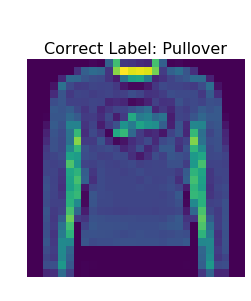

In [88]:
show(test_images[rando].reshape(28,28), 'Correct Label: {}'.format(class_names[test_labels[rando]]))

Print the predicted label from the output of our model

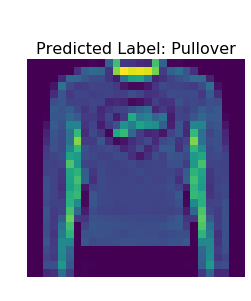

In [89]:
# we need to convert the single image into a list of one item
predictions_single = model.predict(np.expand_dims(test_images[rando],0))

show(test_images[rando].reshape(28,28), 'Predicted Label: {}'.format(class_names[np.argmax(predictions_single[0])]))

## Downloading the saved model

In [46]:
!ls -l {export_path}

total 72
-rw-r--r-- 1 root root 65982 Aug 25 10:52 saved_model.pb
drwxr-xr-x 2 root root  4096 Aug 25 10:52 variables


In [51]:
!zip -r /content/file.zip {export_path}

updating: tmp/1/ (stored 0%)
updating: tmp/1/saved_model.pb (deflated 85%)
updating: tmp/1/variables/ (stored 0%)
updating: tmp/1/variables/variables.data-00000-of-00001 (deflated 6%)
updating: tmp/1/variables/variables.index (deflated 34%)


In [0]:
from google.colab import files
files.download("/content/file.zip")

## Testing the saved model with TF serving

We'll test the saved model with TF serving using its docker image.

### Run the TF serving container

After downloading the saved model files. Run the following docker command to spin up the RESTful service.

Replace the {model_path} with your local path.


```
docker run -t --rm -p 8501:8501 \
```
```
--mount type=bind,source={model_path},target=/models/fashion_model \
```
```
-e MODEL_NAME=fashion_model tensorflow/serving
```



### Testing the model with TF Serving

In [65]:
# pick some random image from the test dataset
import random
rando = random.randint(0,len(test_images)-1)
print("chosen random image: {}".format(rando))

chosen random image: 9634


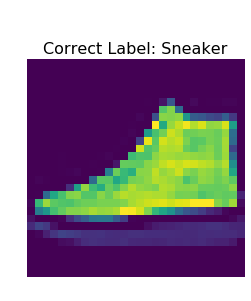

In [66]:
show(test_images[rando].reshape(28,28), 'Correct Label: {}'.format(class_names[test_labels[rando]]))

In [74]:
# preparing the request payload
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images[rando:rando+1].tolist()})
print(data)

{"signature_name": "serving_default", "instances": [[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], 

In [0]:
# a sample request
curl -d '{"signature_name": "serving_default", "instances": [[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.00392156862745098], [0.0], [0.050980392156862744], [0.27058823529411763], [0.0], [0.0], [0.023529411764705882], [0.0], [0.00392156862745098], [0.00392156862745098], [0.011764705882352941], [0.011764705882352941], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.7333333333333333], [0.8156862745098039], [0.34901960784313724], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.01568627450980392], [0.0], [0.24705882352941178], [0.8235294117647058], [0.8156862745098039], [0.8313725490196079], [0.5294117647058824], [0.29411764705882354], [0.27058823529411763], [0.2235294117647059], [0.2], [0.2980392156862745], [0.16470588235294117], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.00392156862745098], [0.0], [0.0], [1.0], [0.6078431372549019], [0.8470588235294118], [0.9137254901960784], [0.984313725490196], [0.8862745098039215], [0.9450980392156862], [0.8352941176470589], [0.8470588235294118], [0.9411764705882353], [0.5647058823529412], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.011764705882352941], [0.0], [0.5529411764705883], [0.7098039215686275], [0.788235294117647], [0.9254901960784314], [0.8823529411764706], [0.7764705882352941], [0.7843137254901961], [0.8], [0.796078431372549], [0.7725490196078432], [0.8431372549019608], [0.3607843137254902], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.00784313725490196], [0.0], [0.2], [0.9686274509803922], [0.7450980392156863], [0.9372549019607843], [0.8941176470588236], [0.9176470588235294], [0.803921568627451], [0.7411764705882353], [0.7490196078431373], [0.796078431372549], [0.7764705882352941], [0.8666666666666667], [0.34509803921568627], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.00392156862745098], [0.0], [0.0], [0.9294117647058824], [0.7294117647058823], [0.7647058823529411], [0.8941176470588236], [0.8784313725490196], [0.8901960784313725], [0.7686274509803922], [0.7411764705882353], [0.792156862745098], [0.8235294117647058], [0.7725490196078432], [0.8627450980392157], [0.2], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.00392156862745098], [0.0], [0.0], [0.0], [0.0], [0.00392156862745098], [0.011764705882352941], [0.0], [0.0], [0.6862745098039216], [0.7254901960784313], [0.7215686274509804], [0.8274509803921568], [0.8705882352941177], [0.8627450980392157], [0.8470588235294118], [0.8549019607843137], [0.8392156862745098], [0.8274509803921568], [0.8392156862745098], [0.7764705882352941], [0.8549019607843137], [0.3411764705882353], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.00392156862745098], [0.0], [0.0], [0.0], [0.00392156862745098], [0.0], [0.0], [0.058823529411764705], [0.7647058823529411], [0.7607843137254902], [0.7529411764705882], [0.8235294117647058], [0.8509803921568627], [0.9058823529411765], [0.9411764705882353], [0.9098039215686274], [0.9411764705882353], [0.9333333333333333], [0.9058823529411765], [0.8862745098039215], [0.8352941176470589], [0.8901960784313725], [0.49411764705882355], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.00392156862745098], [0.00784313725490196], [0.01568627450980392], [0.0], [0.0], [0.00392156862745098], [0.43137254901960786], [0.7764705882352941], [0.6784313725490196], [0.6313725490196078], [0.8235294117647058], [0.8274509803921568], [0.9058823529411765], [0.8431372549019608], [0.8705882352941177], [0.9254901960784314], [0.8274509803921568], [0.8], [0.8470588235294118], [0.8274509803921568], [0.788235294117647], [0.8431372549019608], [0.592156862745098], [0.0]], [[0.0], [0.011764705882352941], [0.00392156862745098], [0.0], [0.0], [0.0], [0.0], [0.0], [0.3411764705882353], [0.7450980392156863], [0.7411764705882353], [0.6], [0.6705882352941176], [0.792156862745098], [0.803921568627451], [0.8352941176470589], [0.8901960784313725], [0.8745098039215686], [0.8509803921568627], [0.8274509803921568], [0.7176470588235294], [0.7725490196078432], [0.8352941176470589], [0.8196078431372549], [0.7764705882352941], [0.807843137254902], [0.7529411764705882], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.13333333333333333], [0.5764705882352941], [0.8392156862745098], [0.6862745098039216], [0.6196078431372549], [0.7725490196078432], [0.7215686274509804], [0.8156862745098039], [0.8862745098039215], [0.8392156862745098], [0.8235294117647058], [0.803921568627451], [0.8862745098039215], [0.8745098039215686], [0.8274509803921568], [0.8196078431372549], [0.8274509803921568], [0.7725490196078432], [0.7686274509803922], [0.7647058823529411], [0.7725490196078432], [0.8274509803921568], [0.0]], [[0.0], [0.00392156862745098], [0.34901960784313724], [0.592156862745098], [0.7098039215686275], [0.8117647058823529], [0.8274509803921568], [0.7333333333333333], [0.7333333333333333], [0.8235294117647058], [0.7725490196078432], [0.8509803921568627], [0.8941176470588236], [0.8705882352941177], [0.8784313725490196], [0.8901960784313725], [0.8784313725490196], [0.8784313725490196], [0.8431372549019608], [0.792156862745098], [0.796078431372549], [0.788235294117647], [0.7254901960784313], [0.7529411764705882], [0.7725490196078432], [0.7568627450980392], [0.7607843137254902], [0.09803921568627451]], [[0.01568627450980392], [0.6705882352941176], [0.8509803921568627], [0.7490196078431373], [0.7294117647058823], [0.7215686274509804], [0.7607843137254902], [0.7803921568627451], [0.7803921568627451], [0.8], [0.8], [0.8], [0.8156862745098039], [0.8705882352941177], [0.8980392156862745], [0.9254901960784314], [0.9411764705882353], [0.9568627450980393], [0.9254901960784314], [0.9529411764705882], [0.9607843137254902], [1.0], [1.0], [1.0], [0.8196078431372549], [0.7686274509803922], [0.8588235294117647], [0.027450980392156862]], [[0.0], [0.4235294117647059], [0.5294117647058824], [0.7019607843137254], [0.7607843137254902], [0.8156862745098039], [0.8156862745098039], [0.8313725490196079], [0.8705882352941177], [0.8431372549019608], [0.8509803921568627], [0.8745098039215686], [1.0], [0.9921568627450981], [0.9372549019607843], [0.8117647058823529], [0.6627450980392157], [0.5882352941176471], [0.5098039215686274], [0.3568627450980392], [0.27058823529411763], [0.23137254901960785], [0.17647058823529413], [0.11372549019607843], [0.0784313725490196], [0.01568627450980392], [0.0], [0.0]], [[0.043137254901960784], [0.0], [0.0], [0.0], [0.011764705882352941], [0.13333333333333333], [0.22745098039215686], [0.29411764705882354], [0.38823529411764707], [0.4], [0.396078431372549], [0.28627450980392155], [0.1803921568627451], [0.00784313725490196], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0196078431372549], [0.06274509803921569]], [[0.12156862745098039], [0.20392156862745098], [0.16470588235294117], [0.047058823529411764], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0392156862745098], [0.07450980392156863], [0.09019607843137255], [0.09803921568627451], [0.10980392156862745], [0.12156862745098039], [0.11764705882352941], [0.12549019607843137], [0.1411764705882353], [0.1411764705882353], [0.12549019607843137], [0.10588235294117647], [0.10196078431372549]], [[0.0], [0.01568627450980392], [0.09019607843137255], [0.15294117647058825], [0.2], [0.1843137254901961], [0.16470588235294117], [0.1411764705882353], [0.1411764705882353], [0.1450980392156863], [0.12941176470588237], [0.12549019607843137], [0.12549019607843137], [0.13725490196078433], [0.13725490196078433], [0.12941176470588237], [0.12941176470588237], [0.12941176470588237], [0.12549019607843137], [0.12156862745098039], [0.11764705882352941], [0.11764705882352941], [0.12941176470588237], [0.12549019607843137], [0.12941176470588237], [0.12549019607843137], [0.12549019607843137], [0.10980392156862745]], [[0.0], [0.0], [0.0], [0.0], [0.03137254901960784], [0.0392156862745098], [0.08235294117647059], [0.12549019607843137], [0.13725490196078433], [0.12941176470588237], [0.12156862745098039], [0.12156862745098039], [0.13333333333333333], [0.11372549019607843], [0.10980392156862745], [0.10980392156862745], [0.10196078431372549], [0.10588235294117647], [0.11764705882352941], [0.11372549019607843], [0.11764705882352941], [0.11372549019607843], [0.12156862745098039], [0.10588235294117647], [0.09411764705882353], [0.09411764705882353], [0.07058823529411765], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}' \
    -X POST http://localhost:8501/v1/models/fashion_model:predict


a sample response from the rest service

```
{
    "predictions": [[1.86554064e-06, 1.45144394e-08, 2.69284072e-07, 1.95202188e-06, 3.31313231e-07, 0.00111654657, 1.40285647e-05, 0.710234165, 0.000198778464, 0.288431972]
    ]
}
```



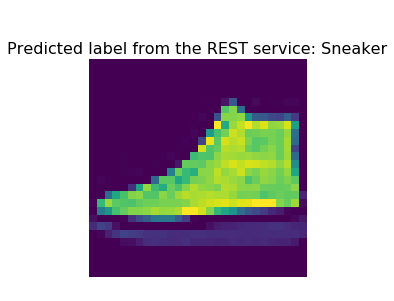

In [75]:
predictions=[[1.86554064e-06, 1.45144394e-08, 2.69284072e-07, 1.95202188e-06, 3.31313231e-07, 0.00111654657, 1.40285647e-05, 0.710234165, 0.000198778464, 0.288431972]]
show(test_images[rando].reshape(28,28), 'Predicted label from the REST service: {}'.format(class_names[np.argmax(predictions[0])]))

## Package the model in a self-contained image

We can package the trained model in self-contained image which directly serves the RESTful api when spinned up.

```
docker run -d --name serving_base tensorflow/serving
```

```
docker cp {model_path} serving_base:/models/fashion_model
```

```
docker commit --change "ENV MODEL_NAME fashion_model" serving_base {new_image_name}
```

```
docker run -t --rm -p 8501:8501 {new_image_name}
```